In [1]:
import pandas as pd 
import numpy as np


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from category_encoders.leave_one_out import LeaveOneOutEncoder

In [2]:
TRANSACTIONS_PATH = r"..\\data\\transactions.csv"
USERS_PATH = r"..\\data\\users.csv"

In [3]:
RANDOM_STATE_SEED = 100

In [4]:
transactions_original_df = pd.read_csv(TRANSACTIONS_PATH,low_memory=True)
users_original_df = pd.read_csv(USERS_PATH,low_memory=True)

## Data Preparation

In [5]:
transactions_original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688651 entries, 0 to 688650
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CURRENCY           688651 non-null  object 
 1   AMOUNT             688651 non-null  int64  
 2   STATE              688651 non-null  object 
 3   CREATED_DATE       688651 non-null  object 
 4   MERCHANT_CATEGORY  223065 non-null  object 
 5   MERCHANT_COUNTRY   483055 non-null  object 
 6   ENTRY_METHOD       688651 non-null  object 
 7   USER_ID            688651 non-null  object 
 8   TYPE               688651 non-null  object 
 9   SOURCE             688651 non-null  object 
 10  ID                 688651 non-null  object 
 11  AMOUNT_USD         635328 non-null  float64
dtypes: float64(1), int64(1), object(10)
memory usage: 63.0+ MB


In [6]:
transactions_original_df.shape

(688651, 12)

In [7]:
users_original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       9944 non-null   object
 1   HAS_EMAIL                9944 non-null   int64 
 2   PHONE_COUNTRY            9944 non-null   object
 3   IS_FRAUDSTER             9944 non-null   bool  
 4   TERMS_VERSION            8417 non-null   object
 5   CREATED_DATE             9944 non-null   object
 6   STATE                    9944 non-null   object
 7   COUNTRY                  9944 non-null   object
 8   BIRTH_YEAR               9944 non-null   int64 
 9   KYC                      9944 non-null   object
 10  FAILED_SIGN_IN_ATTEMPTS  9944 non-null   int64 
dtypes: bool(1), int64(3), object(7)
memory usage: 786.7+ KB


In [8]:
users_original_df.shape

(9944, 11)

In [9]:
transactions_original_df.head()

,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID,AMOUNT_USD
0,GBP,4420,COMPLETED,2017-12-10 16:38:55.577,NaN,NLD,chip,3ff52b92-d416-4e22-8cad-018f500d4bbc,ATM,GAIA,367bf5f9-7cce-4683-90b9-d3c011bf4c87,3268.0
1,PLN,1500,COMPLETED,2017-12-10 16:37:24.792,point_of_interest,POL,manu,76cbaad3-4721-4a3b-92b9-3eb9e9319565,CARD_PAYMENT,GAIA,ff6802b9-360d-4efe-b09b-f99c6cac3383,NaN
2,GBP,191,COMPLETED,2017-12-10 16:37:16.234,airport,PRT,chip,7bcaa34e-b889-4582-9c29-0b3bab34fb8c,CARD_PAYMENT,GAIA,ddb4a930-7d8a-4f38-9079-ddc4b0db980e,141.0
3,GBP,10000,COMPLETED,2017-12-10 16:34:42.592,NaN,NaN,misc,b3a6762b-a940-4459-bb1d-8e28e151f901,TOPUP,HERA,080ef0be-850a-4f14-ab03-28ff68e6b797,7394.0
4,EUR,1159,COMPLETED,2017-12-10 16:34:17.88,NaN,FRA,manu,f5723f5e-5a00-4851-ae1d-5c11146aa491,CARD_PAYMENT,GAIA,bd13abac-4004-4c67-9bb7-90a42b027e82,977.0


In [10]:
transactions_original_df.rename({'ID':"TRANSACTION_ID"},inplace=True, axis=1)

In [11]:
transactions_original_df.rename({'STATE':"TRANSACTION_STATUS"},inplace=True, axis=1)

In [12]:
transactions_original_df.rename({'CREATED_DATE':"TRANSACTION_CREATED_DATE"},inplace=True, axis=1)

In [13]:
transactions_original_df.columns

Index(['CURRENCY', 'AMOUNT', 'TRANSACTION_STATUS', 'TRANSACTION_CREATED_DATE',
       'MERCHANT_CATEGORY', 'MERCHANT_COUNTRY', 'ENTRY_METHOD', 'USER_ID',
       'TYPE', 'SOURCE', 'TRANSACTION_ID', 'AMOUNT_USD'],
      dtype='object')

In [14]:
users_original_df.head()

,ID,HAS_EMAIL,PHONE_COUNTRY,IS_FRAUDSTER,TERMS_VERSION,CREATED_DATE,STATE,COUNTRY,BIRTH_YEAR,KYC,FAILED_SIGN_IN_ATTEMPTS
0,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,False,2018-05-25,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,0
1,545ff94d-66f8-4bea-b398-84425fb2301e,1,GB||JE||IM||GG,False,2018-01-01,2017-03-07 10:18:59.427000,ACTIVE,GB,1982,PASSED,0
2,10376f1a-a28a-4885-8daa-c8ca496026bb,1,ES,False,2018-09-20,2018-05-31 04:41:24.672000,ACTIVE,ES,1973,PASSED,0
3,fd308db7-0753-4377-879f-6ecf2af14e4f,1,FR,False,2018-05-25,2018-06-01 17:24:23.852000,ACTIVE,FR,1986,PASSED,0
4,755fe256-a34d-4853-b7ca-d9bb991a86d3,1,GB||JE||IM||GG,False,2018-09-20,2017-08-09 15:03:33.945000,ACTIVE,GB,1989,PASSED,0


In [15]:
users_original_df.rename({'STATE':"USER_STATUS"},inplace=True, axis=1)

In [16]:
users_original_df.rename({'CREATED_DATE':"USER_CREATED_DATE"},inplace=True, axis=1)

In [17]:
users_original_df.rename(columns={"ID":"USER_ID"},inplace=True)

In [18]:
users_original_df.columns

Index(['USER_ID', 'HAS_EMAIL', 'PHONE_COUNTRY', 'IS_FRAUDSTER',
       'TERMS_VERSION', 'USER_CREATED_DATE', 'USER_STATUS', 'COUNTRY',
       'BIRTH_YEAR', 'KYC', 'FAILED_SIGN_IN_ATTEMPTS'],
      dtype='object')

### Merging two Dataframes

In [19]:
transactions_users_join_df = pd.merge(left=users_original_df,
                                      right=transactions_original_df,
                                      on  = "USER_ID",
                                      how = 'left')

In [20]:
transactions_users_join_df.head()

,USER_ID,HAS_EMAIL,PHONE_COUNTRY,IS_FRAUDSTER,TERMS_VERSION,USER_CREATED_DATE,USER_STATUS,COUNTRY,BIRTH_YEAR,KYC,...,AMOUNT,TRANSACTION_STATUS,TRANSACTION_CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,TYPE,SOURCE,TRANSACTION_ID,AMOUNT_USD
0,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,False,2018-05-25,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,...,50000.0,COMPLETED,2018-05-31 17:26:00.205,NaN,NaN,misc,TOPUP,HERA,29df55ae-accd-47c2-85f6-ed499703b75d,37130.0
1,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,False,2018-05-25,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,...,25000.0,COMPLETED,2018-06-01 13:25:04.633,NaN,ITA,chip,ATM,GAIA,986cc473-36f8-46e4-9433-44f22a521e8b,21007.0
2,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,False,2018-05-25,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,...,2220.0,COMPLETED,2018-06-03 12:34:33.408,NaN,ITA,chip,CARD_PAYMENT,GAIA,ab12425e-ab5a-4021-8a4e-a344ea7af43e,1907.0
3,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,False,2018-05-25,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,...,1190.0,COMPLETED,2018-06-03 14:54:26.835,airport,ITA,cont,CARD_PAYMENT,GAIA,36ea2aa1-93bb-4cec-89cf-5c79d24d93ec,1009.0
4,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,False,2018-05-25,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,...,1000.0,COMPLETED,2017-08-12 12:17:40.762,NaN,NaN,misc,TOPUP,HERA,1a050680-bb84-436f-a93b-79b7e75775db,749.0


In [21]:
# check for duplicates in the transaction ID column
duplicates = transactions_users_join_df.duplicated(subset=['TRANSACTION_ID'])

# print result
if duplicates.any():
    print("There are duplicate transaction IDs in the transaction ID column.")
else:
    print("Every transaction ID is unique in the transaction ID column.")

There are duplicate transaction IDs in the transaction ID column.


In [22]:
unique_txns_df = pd.DataFrame(transactions_users_join_df['TRANSACTION_ID'].value_counts())

In [23]:
transactions_users_join_df[transactions_users_join_df.duplicated(subset='TRANSACTION_ID', keep=False)]

,USER_ID,HAS_EMAIL,PHONE_COUNTRY,IS_FRAUDSTER,TERMS_VERSION,USER_CREATED_DATE,USER_STATUS,COUNTRY,BIRTH_YEAR,KYC,...,AMOUNT,TRANSACTION_STATUS,TRANSACTION_CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,TYPE,SOURCE,TRANSACTION_ID,AMOUNT_USD
436,25356d21-d942-47d5-b3a9-d521c79a2ae6,1,PL,False,2018-01-13,2017-12-15 17:22:24.663000,ACTIVE,PL,1983,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
514,c09d96d6-af80-427e-b3ce-33dde700902a,1,GB||JE||IM||GG,False,2018-05-25,2018-06-04 17:18:50.672000,ACTIVE,GB,1978,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
748,3280f3fd-a299-4be0-8392-47a0306f3dc4,1,ES,False,2018-05-25,2018-06-10 14:17:47.541000,ACTIVE,ES,1992,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
785,5e2d047c-7fbe-4093-988e-dbce6de196f7,0,GR,False,NaN,2016-03-25 18:43:05.920000,ACTIVE,GR,1981,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
786,246e5f8d-024c-46d3-8e66-8ef2fc64628c,1,GB||JE||IM||GG,False,NaN,2016-10-27 19:50:10.244000,ACTIVE,GB,1950,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640438,e53276ac-25af-4000-bede-80ceaeb096cd,0,GB||JE||IM||GG,False,NaN,2017-01-17 17:23:22.178000,ACTIVE,GB,1972,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
640439,06453995-2ee9-4627-8ee6-33ac086497c2,1,ES,False,2018-05-25,2018-06-08 13:34:36.553000,ACTIVE,ES,1967,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
640933,438f235a-3f6e-4663-ba95-fa107b11bfc5,1,LT,False,2018-01-13,2017-12-20 11:00:03.873000,ACTIVE,LT,1994,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
640936,55995ada-5797-4f7e-82da-62a3d4051e8b,1,GB||JE||IM||GG,False,2018-03-20,2018-02-23 16:24:40.716000,ACTIVE,GB,1961,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
transactions_users_join_df.isnull().sum()

USER_ID                          0
HAS_EMAIL                        0
PHONE_COUNTRY                    0
IS_FRAUDSTER                     0
TERMS_VERSION                26302
USER_CREATED_DATE                0
USER_STATUS                      0
COUNTRY                          0
BIRTH_YEAR                       0
KYC                              0
FAILED_SIGN_IN_ATTEMPTS          0
CURRENCY                      2196
AMOUNT                        2196
TRANSACTION_STATUS            2196
TRANSACTION_CREATED_DATE      2196
MERCHANT_CATEGORY           432261
MERCHANT_COUNTRY            193921
ENTRY_METHOD                  2196
TYPE                          2196
SOURCE                        2196
TRANSACTION_ID                2196
AMOUNT_USD                   54813
dtype: int64

In [25]:
transactions_users_join_df['TRANSACTION_ID'].shape

(640938,)

In [26]:
transactions_users_join_df.dropna(subset=['TRANSACTION_ID'], inplace=True)

In [27]:
# check for duplicates in the transaction ID column
duplicates = transactions_users_join_df.duplicated(subset=['TRANSACTION_ID'])

# print result
if duplicates.any():
    print("There are duplicate transaction IDs in the transaction ID column.")
else:
    print("Every transaction ID is unique in the transaction ID column.")

Every transaction ID is unique in the transaction ID column.


In [28]:
transactions_users_join_df.set_index("TRANSACTION_ID",inplace=True)

In [29]:
fraudster_col = transactions_users_join_df.pop('IS_FRAUDSTER')
transactions_users_join_df = transactions_users_join_df.assign(IS_FRAUDSTER=fraudster_col)

In [30]:
transactions_users_join_df.head()

,USER_ID,HAS_EMAIL,PHONE_COUNTRY,TERMS_VERSION,USER_CREATED_DATE,USER_STATUS,COUNTRY,BIRTH_YEAR,KYC,FAILED_SIGN_IN_ATTEMPTS,...,AMOUNT,TRANSACTION_STATUS,TRANSACTION_CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,TYPE,SOURCE,AMOUNT_USD,IS_FRAUDSTER
TRANSACTION_ID,,,,,,,,,,,,,,,,,,,,,
29df55ae-accd-47c2-85f6-ed499703b75d,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,2018-05-25,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,0,...,50000.0,COMPLETED,2018-05-31 17:26:00.205,NaN,NaN,misc,TOPUP,HERA,37130.0,False
986cc473-36f8-46e4-9433-44f22a521e8b,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,2018-05-25,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,0,...,25000.0,COMPLETED,2018-06-01 13:25:04.633,NaN,ITA,chip,ATM,GAIA,21007.0,False
ab12425e-ab5a-4021-8a4e-a344ea7af43e,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,2018-05-25,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,0,...,2220.0,COMPLETED,2018-06-03 12:34:33.408,NaN,ITA,chip,CARD_PAYMENT,GAIA,1907.0,False
36ea2aa1-93bb-4cec-89cf-5c79d24d93ec,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,2018-05-25,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,0,...,1190.0,COMPLETED,2018-06-03 14:54:26.835,airport,ITA,cont,CARD_PAYMENT,GAIA,1009.0,False
1a050680-bb84-436f-a93b-79b7e75775db,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,2018-05-25,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,0,...,1000.0,COMPLETED,2017-08-12 12:17:40.762,NaN,NaN,misc,TOPUP,HERA,749.0,False


In [31]:
transactions_users_join_df["IS_FRAUDSTER"].value_counts()

False    624828
True      13914
Name: IS_FRAUDSTER, dtype: int64

In [32]:
transactions_users_join_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 638742 entries, 29df55ae-accd-47c2-85f6-ed499703b75d to 9995959c-38af-49da-b568-d7764efa4d00
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   USER_ID                   638742 non-null  object 
 1   HAS_EMAIL                 638742 non-null  int64  
 2   PHONE_COUNTRY             638742 non-null  object 
 3   TERMS_VERSION             613084 non-null  object 
 4   USER_CREATED_DATE         638742 non-null  object 
 5   USER_STATUS               638742 non-null  object 
 6   COUNTRY                   638742 non-null  object 
 7   BIRTH_YEAR                638742 non-null  int64  
 8   KYC                       638742 non-null  object 
 9   FAILED_SIGN_IN_ATTEMPTS   638742 non-null  int64  
 10  CURRENCY                  638742 non-null  object 
 11  AMOUNT                    638742 non-null  float64
 12  TRANSACTION_STATUS        638742 non-nul

In [33]:
transactions_users_join_df.isnull().sum()

USER_ID                          0
HAS_EMAIL                        0
PHONE_COUNTRY                    0
TERMS_VERSION                25658
USER_CREATED_DATE                0
USER_STATUS                      0
COUNTRY                          0
BIRTH_YEAR                       0
KYC                              0
FAILED_SIGN_IN_ATTEMPTS          0
CURRENCY                         0
AMOUNT                           0
TRANSACTION_STATUS               0
TRANSACTION_CREATED_DATE         0
MERCHANT_CATEGORY           430065
MERCHANT_COUNTRY            191725
ENTRY_METHOD                     0
TYPE                             0
SOURCE                           0
AMOUNT_USD                   52617
IS_FRAUDSTER                     0
dtype: int64

In [34]:
transactions_users_join_df = transactions_users_join_df.dropna(subset=['AMOUNT_USD'])

In [35]:
transactions_users_join_df["IS_FRAUDSTER"].value_counts()

False    572522
True      13603
Name: IS_FRAUDSTER, dtype: int64

In [36]:
transactions_users_join_df.isnull().sum()

USER_ID                          0
HAS_EMAIL                        0
PHONE_COUNTRY                    0
TERMS_VERSION                25196
USER_CREATED_DATE                0
USER_STATUS                      0
COUNTRY                          0
BIRTH_YEAR                       0
KYC                              0
FAILED_SIGN_IN_ATTEMPTS          0
CURRENCY                         0
AMOUNT                           0
TRANSACTION_STATUS               0
TRANSACTION_CREATED_DATE         0
MERCHANT_CATEGORY           391738
MERCHANT_COUNTRY            176171
ENTRY_METHOD                     0
TYPE                             0
SOURCE                           0
AMOUNT_USD                       0
IS_FRAUDSTER                     0
dtype: int64

In [37]:
transactions_users_join_df['MERCHANT_CATEGORY'].fillna('unknown_merchant_category',inplace=True)

In [38]:
transactions_users_join_df['MERCHANT_COUNTRY'].fillna('unknown_merchant_country',inplace=True)

In [39]:
transactions_users_join_df.isnull().sum()

USER_ID                         0
HAS_EMAIL                       0
PHONE_COUNTRY                   0
TERMS_VERSION               25196
USER_CREATED_DATE               0
USER_STATUS                     0
COUNTRY                         0
BIRTH_YEAR                      0
KYC                             0
FAILED_SIGN_IN_ATTEMPTS         0
CURRENCY                        0
AMOUNT                          0
TRANSACTION_STATUS              0
TRANSACTION_CREATED_DATE        0
MERCHANT_CATEGORY               0
MERCHANT_COUNTRY                0
ENTRY_METHOD                    0
TYPE                            0
SOURCE                          0
AMOUNT_USD                      0
IS_FRAUDSTER                    0
dtype: int64

In [40]:
transactions_users_join_df.drop(["TERMS_VERSION"],axis=1,inplace=True)

In [41]:
transactions_users_join_df.head()

,USER_ID,HAS_EMAIL,PHONE_COUNTRY,USER_CREATED_DATE,USER_STATUS,COUNTRY,BIRTH_YEAR,KYC,FAILED_SIGN_IN_ATTEMPTS,CURRENCY,AMOUNT,TRANSACTION_STATUS,TRANSACTION_CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,TYPE,SOURCE,AMOUNT_USD,IS_FRAUDSTER
TRANSACTION_ID,,,,,,,,,,,,,,,,,,,,
29df55ae-accd-47c2-85f6-ed499703b75d,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,0,GBP,50000.0,COMPLETED,2018-05-31 17:26:00.205,unknown_merchant_category,unknown_merchant_country,misc,TOPUP,HERA,37130.0,False
986cc473-36f8-46e4-9433-44f22a521e8b,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,0,EUR,25000.0,COMPLETED,2018-06-01 13:25:04.633,unknown_merchant_category,ITA,chip,ATM,GAIA,21007.0,False
ab12425e-ab5a-4021-8a4e-a344ea7af43e,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,0,EUR,2220.0,COMPLETED,2018-06-03 12:34:33.408,unknown_merchant_category,ITA,chip,CARD_PAYMENT,GAIA,1907.0,False
36ea2aa1-93bb-4cec-89cf-5c79d24d93ec,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,0,EUR,1190.0,COMPLETED,2018-06-03 14:54:26.835,airport,ITA,cont,CARD_PAYMENT,GAIA,1009.0,False
1a050680-bb84-436f-a93b-79b7e75775db,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,0,GBP,1000.0,COMPLETED,2017-08-12 12:17:40.762,unknown_merchant_category,unknown_merchant_country,misc,TOPUP,HERA,749.0,False


In [42]:
transactions_users_join_df.to_csv("merged_transaction_user_history.csv")

## Feature Engineering

In [43]:
# Split the data into training and test sets (70% training and 30% test)
train_val_df, test_df = train_test_split(transactions_users_join_df,
                                         test_size=0.2,
                                         random_state=RANDOM_STATE_SEED,
                                         stratify=transactions_users_join_df['IS_FRAUDSTER'])

# Split the training data into training and validation sets (70% training and 30% validation)
train_df, val_df = train_test_split(train_val_df,
                                    test_size=0.3,
                                    random_state=RANDOM_STATE_SEED,
                                    stratify=train_val_df['IS_FRAUDSTER'])

In [44]:
train_df.head()

,USER_ID,HAS_EMAIL,PHONE_COUNTRY,USER_CREATED_DATE,USER_STATUS,COUNTRY,BIRTH_YEAR,KYC,FAILED_SIGN_IN_ATTEMPTS,CURRENCY,AMOUNT,TRANSACTION_STATUS,TRANSACTION_CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,TYPE,SOURCE,AMOUNT_USD,IS_FRAUDSTER
TRANSACTION_ID,,,,,,,,,,,,,,,,,,,,
aced2eea-ba97-4fc8-8544-5610b65dd815,12d6a3c2-0ea7-4143-b2b9-1e0384bedb70,1,IE,2017-06-08 11:07:59.283000,ACTIVE,IE,1989,PASSED,0,EUR,480.0,COMPLETED,2017-08-05 18:39:14.301,cafe,IRL,cont,CARD_PAYMENT,GAIA,405.0,False
d9601c74-4354-4f84-9846-43ca9a9aedde,2157bdf7-d13f-4363-8c83-60c4d1f5196c,1,IT,2016-09-20 14:18:52.260000,ACTIVE,IT,1960,NONE,0,EUR,1000.0,REVERTED,2016-12-20 14:06:59.709,unknown_merchant_category,unknown_merchant_country,misc,TOPUP,HERA,856.0,False
8a66e62f-95a5-4bec-86dd-9fa64d285444,582e55c9-7848-4e3d-ab51-01e59e725497,1,IE,2017-08-18 16:12:59.349000,ACTIVE,IE,1990,PASSED,0,EUR,1835.0,COMPLETED,2017-09-30 20:55:50.066,bar,GBR,cont,CARD_PAYMENT,GAIA,1557.0,False
8bcbad08-654f-4d0d-a10c-0f0343e074ed,e65fb708-8e29-4057-abf3-292546702d67,1,GB||JE||IM||GG,2017-12-21 11:07:13.519000,ACTIVE,GB,1989,PASSED,0,EUR,15295.0,COMPLETED,2018-06-08 21:14:08.386,unknown_merchant_category,DEU,chip,ATM,GAIA,12891.0,False
fbd6ad8d-6af9-4c2f-b4bf-14d5f146a764,f3c9be4e-5bd6-42dd-ad8e-f7baad521d00,1,GB||JE||IM||GG,2016-12-22 12:01:06.421000,ACTIVE,GB,1982,PASSED,0,GBP,22.0,COMPLETED,2018-06-22 15:54:26.33,unknown_merchant_category,unknown_merchant_country,misc,P2P,INTERNAL,16.0,False


In [45]:
### TRAIN DATASET ###
# Convert the datetime columns to datetime format
train_df['USER_CREATED_DATE'] = pd.to_datetime(train_df['USER_CREATED_DATE'],infer_datetime_format=True,format='mixed')
train_df['TRANSACTION_CREATED_DATE'] = pd.to_datetime(train_df['TRANSACTION_CREATED_DATE'],infer_datetime_format=True,format='mixed')

# Calculate the time difference between the two columns
train_df['TIME_PASSED'] = train_df['TRANSACTION_CREATED_DATE'] - train_df['USER_CREATED_DATE']
train_df['TIME_PASSED_IN_DAYS'] = train_df['TIME_PASSED'].dt.days
train_df.drop(['TIME_PASSED'],axis=1,inplace=True)

In [46]:
### TEST AND VALIDATION DATASET ###

### TEST ###
test_df['USER_CREATED_DATE'] = pd.to_datetime(test_df['USER_CREATED_DATE'],infer_datetime_format=True,format='mixed')
test_df['TRANSACTION_CREATED_DATE'] = pd.to_datetime(test_df['TRANSACTION_CREATED_DATE'],infer_datetime_format=True,format='mixed')

# Calculate the time difference between the two columns
test_df['TIME_PASSED'] = test_df['TRANSACTION_CREATED_DATE'] - test_df['USER_CREATED_DATE']
test_df['TIME_PASSED_IN_DAYS'] = test_df['TIME_PASSED'].dt.days
test_df.drop(['TIME_PASSED'],axis=1,inplace=True)

### VALIDATION ### 
val_df['USER_CREATED_DATE'] = pd.to_datetime(val_df['USER_CREATED_DATE'],infer_datetime_format=True,format='mixed')
val_df['TRANSACTION_CREATED_DATE'] = pd.to_datetime(val_df['TRANSACTION_CREATED_DATE'],infer_datetime_format=True,format='mixed')

# Calculate the time difference between the two columns
val_df['TIME_PASSED'] = val_df['TRANSACTION_CREATED_DATE'] - val_df['USER_CREATED_DATE']
val_df['TIME_PASSED_IN_DAYS'] = val_df['TIME_PASSED'].dt.days
val_df.drop(['TIME_PASSED'],axis=1,inplace=True)

In [47]:
### TRAIN DATASET ###
train_df.drop(['USER_CREATED_DATE','TRANSACTION_CREATED_DATE'],axis=1,inplace=True)

In [48]:
### TEST AND VALIDATION DATASET ###
test_df.drop(['USER_CREATED_DATE','TRANSACTION_CREATED_DATE'],axis=1,inplace=True)
val_df.drop(['USER_CREATED_DATE','TRANSACTION_CREATED_DATE'],axis=1,inplace=True)

In [49]:
train_df['USER_STATUS'].unique()

array(['ACTIVE', 'LOCKED'], dtype=object)

In [50]:
### TRAIN DATASET ###
train_df['USER_STATUS'] = train_df['USER_STATUS'].map({'ACTIVE':1,'LOCKED':0})

In [51]:
### TEST AND VALIDATION DATASET ###
test_df['USER_STATUS'] = test_df['USER_STATUS'].map({'ACTIVE':1,'LOCKED':0})
val_df['USER_STATUS'] = val_df['USER_STATUS'].map({'ACTIVE':1,'LOCKED':0})

In [52]:
train_df['KYC'].unique()

array(['PASSED', 'NONE', 'PENDING', 'FAILED'], dtype=object)

In [53]:
### TRAIN DATASET ###
train_df['KYC'] = train_df['KYC'].map({'PASSED': 3, 'PENDING': 2, 'NONE': 1, 'FAILED': 0})

In [54]:
### TEST AND VALIDATION DATASET ###
test_df['KYC'] = test_df['KYC'].map({'PASSED': 3, 'PENDING': 2, 'NONE': 1, 'FAILED': 0})
val_df['KYC'] = val_df['KYC'].map({'PASSED': 3, 'PENDING': 2, 'NONE': 1, 'FAILED': 0})

In [55]:
train_df['TRANSACTION_STATUS'].unique()

array(['COMPLETED', 'REVERTED', 'FAILED', 'DECLINED', 'PENDING',
       'CANCELLED', 'RECORDED'], dtype=object)

In [56]:
### TRAIN DATASET ###
train_df['TRANSACTION_STATUS']=\
train_df['TRANSACTION_STATUS'].map({
    'FAILED': 0,
    'DECLINED': 1,
    'CANCELLED': 2,
    'REVERTED': 3,
    'PENDING': 4,
    'RECORDED': 5,
    'COMPLETED': 6
})

In [57]:
### TEST AND VALIDATION DATASET ###

test_df['TRANSACTION_STATUS']=\
test_df['TRANSACTION_STATUS'].map({
    'FAILED': 0,
    'DECLINED': 1,
    'CANCELLED': 2,
    'REVERTED': 3,
    'PENDING': 4,
    'RECORDED': 5,
    'COMPLETED': 6
})

val_df['TRANSACTION_STATUS']=\
val_df['TRANSACTION_STATUS'].map({
    'FAILED': 0,
    'DECLINED': 1,
    'CANCELLED': 2,
    'REVERTED': 3,
    'PENDING': 4,
    'RECORDED': 5,
    'COMPLETED': 6
})

In [58]:
### TRAIN DATASET ###
train_df['IS_FRAUDSTER'] = train_df['IS_FRAUDSTER'].map({False: 0, True: 1})

In [59]:
### TEST AND VALIDATION DATASET ###
test_df['IS_FRAUDSTER'] = test_df['IS_FRAUDSTER'].map({False: 0, True: 1})
val_df['IS_FRAUDSTER'] = val_df['IS_FRAUDSTER'].map({False: 0, True: 1})

In [60]:
### TRAIN DATASET ###
# calculate the age
train_df['AGE'] = 2018 - train_df['BIRTH_YEAR']
train_df.drop(['BIRTH_YEAR'],axis=1,inplace=True)

In [61]:
### TEST AND VALIDATION DATASET ###

# calculate the age
test_df['AGE'] = 2018 - test_df['BIRTH_YEAR']
test_df.drop(['BIRTH_YEAR'],axis=1,inplace=True)

# calculate the age
val_df['AGE'] = 2018 - val_df['BIRTH_YEAR']
val_df.drop(['BIRTH_YEAR'],axis=1,inplace=True)

In [62]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 328230 entries, aced2eea-ba97-4fc8-8544-5610b65dd815 to 82225e94-fa34-4791-aea6-71320de77c60
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   USER_ID                  328230 non-null  object 
 1   HAS_EMAIL                328230 non-null  int64  
 2   PHONE_COUNTRY            328230 non-null  object 
 3   USER_STATUS              328230 non-null  int64  
 4   COUNTRY                  328230 non-null  object 
 5   KYC                      328230 non-null  int64  
 6   FAILED_SIGN_IN_ATTEMPTS  328230 non-null  int64  
 7   CURRENCY                 328230 non-null  object 
 8   AMOUNT                   328230 non-null  float64
 9   TRANSACTION_STATUS       328230 non-null  int64  
 10  MERCHANT_CATEGORY        328230 non-null  object 
 11  MERCHANT_COUNTRY         328230 non-null  object 
 12  ENTRY_METHOD             328230 non-null  object 
 13 

In [63]:
train_df['PHONE_COUNTRY'].unique()

array(['IE', 'IT', 'GB||JE||IM||GG', 'US||PR||CA', 'FR', 'PT', 'LT', 'ES',
       'SK', 'MT', 'RO', 'EE', 'LV', 'BG', 'DE', 'CH', 'CY', 'PL', 'NZ',
       'FI||AX', 'NL', 'GR', 'HU', 'IS', 'IN', 'BE', 'SI', 'SE', 'GI',
       'KR', 'CZ', 'CC||CX||AU', 'DK', 'AT', 'NO||SJ||BV', 'MO', 'HR',
       'LU', 'QA', 'TH', 'EG', 'CN', 'IL', 'VN', 'AE', 'BR', 'JP', 'HK',
       'KY', 'NC', 'AR', 'MK', 'EH||MA', 'ZA', 'BN', 'RU||KZ', 'GF',
       'BL||MF||GP', 'UA', 'AL', 'GE', 'TF||RE||YT', 'ID', 'MY', 'PH',
       'JO', 'PE', 'MQ', 'CM', 'AZ'], dtype=object)

In [64]:
### TRAIN DATASET ###
train_df['PHONE_COUNTRY'] = train_df['PHONE_COUNTRY'].apply(lambda x: x.split("||"))

In [65]:
### TEST AND VALIDATION DATASET ###
test_df['PHONE_COUNTRY'] = test_df['PHONE_COUNTRY'].apply(lambda x: x.split("||"))
val_df['PHONE_COUNTRY'] = val_df['PHONE_COUNTRY'].apply(lambda x: x.split("||"))

In [66]:
### TRAIN DATASET ###
# Create MultiLabelBinarizer object
mlb = MultiLabelBinarizer()

# Fit and transform the PHONE_COUNTRY column
encoded_phone_countries = mlb.fit_transform(train_df['PHONE_COUNTRY'])

# Get the names of the encoded columns
unique_phone_countries = mlb.classes_

In [67]:
## SAVE THE MULTI_LABEL BINARIZER AS PICKLE FILE
import pickle
# Save MultiLabelBinarizer object to a pickle file
with open('MultiLabelBinarizer.pkl', 'wb') as f:
    pickle.dump(mlb, f)

In [68]:
### TEST AND VALIDATION DATASET ###
# Transform the PHONE_COUNTRY column
encoded_phone_countries_test = mlb.transform(test_df['PHONE_COUNTRY'])
encoded_phone_countries_val = mlb.transform(val_df['PHONE_COUNTRY'])

c:\Users\Shubham Singh\.virtualenvs\revolut_detect_fraud\lib\site-packages\sklearn\preprocessing\_label.py:895: UserWarning: unknown class(es) ['MX', 'TR'] will be ignored
  warnings.warn(
c:\Users\Shubham Singh\.virtualenvs\revolut_detect_fraud\lib\site-packages\sklearn\preprocessing\_label.py:895: UserWarning: unknown class(es) ['ME'] will be ignored
  warnings.warn(


In [69]:
### TRAIN DATASET ###
# Create a new dataframe with the encoded columns
encoded_phone_countries_df = pd.DataFrame(encoded_phone_countries, columns=unique_phone_countries,index=train_df.index)

In [70]:
### TEST AND VALIDATION DATASET ###
encoded_phone_countries_test_df = pd.DataFrame(encoded_phone_countries_test,
                                               columns=unique_phone_countries,
                                               index=test_df.index)
encoded_phone_countries_val_df = pd.DataFrame(encoded_phone_countries_val,
                                              columns=unique_phone_countries,
                                              index=val_df.index)

In [71]:
encoded_phone_countries_df.head()

,AE,AL,AR,AT,AU,AX,AZ,BE,BG,BL,...,SI,SJ,SK,TF,TH,UA,US,VN,YT,ZA
TRANSACTION_ID,,,,,,,,,,,,,,,,,,,,,
aced2eea-ba97-4fc8-8544-5610b65dd815,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
d9601c74-4354-4f84-9846-43ca9a9aedde,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8a66e62f-95a5-4bec-86dd-9fa64d285444,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8bcbad08-654f-4d0d-a10c-0f0343e074ed,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fbd6ad8d-6af9-4c2f-b4bf-14d5f146a764,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
### TRAIN DATASET ###
# concatenate the two dataframes along the columns axis
train_df = pd.concat([train_df, encoded_phone_countries_df], axis=1)

# drop the original PHONE_COUNTRY column
train_df = train_df.drop('PHONE_COUNTRY', axis=1)

In [73]:
### TEST AND VALIDATION DATASET ###
### TEST DATASET ###
# concatenate the two dataframes along the columns axis
test_df = pd.concat([test_df, encoded_phone_countries_test_df], axis=1)

# drop the original PHONE_COUNTRY column
test_df = test_df.drop('PHONE_COUNTRY', axis=1)

### VALIDATION DATASET ###
# concatenate the two dataframes along the columns axis
val_df = pd.concat([val_df, encoded_phone_countries_val_df], axis=1)

# drop the original PHONE_COUNTRY column
val_df = val_df.drop('PHONE_COUNTRY', axis=1)

In [74]:
### TRAIN DATASET ###
leave_one_out_encoder = LeaveOneOutEncoder() # For Country and Currency
train_df[['COUNTRY','CURRENCY','MERCHANT_CATEGORY','MERCHANT_COUNTRY','ENTRY_METHOD','TYPE','SOURCE']] = \
    leave_one_out_encoder.fit_transform(X=train_df[['COUNTRY','CURRENCY','MERCHANT_CATEGORY','MERCHANT_COUNTRY','ENTRY_METHOD','TYPE','SOURCE']],
                                        y=train_df['IS_FRAUDSTER'])

In [75]:
### TEST AND VALIDATION DATASET ###
test_df[['COUNTRY','CURRENCY','MERCHANT_CATEGORY','MERCHANT_COUNTRY','ENTRY_METHOD','TYPE','SOURCE']] = \
    leave_one_out_encoder.transform(X=test_df[['COUNTRY','CURRENCY','MERCHANT_CATEGORY','MERCHANT_COUNTRY','ENTRY_METHOD','TYPE','SOURCE']])
    
val_df[['COUNTRY','CURRENCY','MERCHANT_CATEGORY','MERCHANT_COUNTRY','ENTRY_METHOD','TYPE','SOURCE']] = \
    leave_one_out_encoder.transform(X=val_df[['COUNTRY','CURRENCY','MERCHANT_CATEGORY','MERCHANT_COUNTRY','ENTRY_METHOD','TYPE','SOURCE']])

In [76]:
## SAVE LEAVE ONE OUT ENCODER
import pickle
# Save MultiLabelBinarizer object to a pickle file
with open('LeaveOneOutEncoder.pkl', 'wb') as f:
    pickle.dump(leave_one_out_encoder, f)

In [77]:
### TRAIN DATASET ###
train_df.drop(['USER_ID'],axis=1,inplace=True)

In [78]:
### TEST AND VALIDATION DATASET ###
test_df.drop(['USER_ID'],axis=1,inplace=True)
val_df.drop(['USER_ID'],axis=1,inplace=True)

In [79]:
train_df.to_csv("train_feature_engineered_transactions.csv")

## Feature Selection

In [80]:
from matplotlib import pyplot as plt
import seaborn as sns

import xgboost as xgb
import plotly.graph_objs as go

In [81]:
REMOVED_FEATURES = []

### Correlation Matrix

In [82]:
train_df.iloc[:,:-86].columns

Index(['HAS_EMAIL', 'USER_STATUS', 'COUNTRY', 'KYC', 'FAILED_SIGN_IN_ATTEMPTS',
       'CURRENCY', 'AMOUNT', 'TRANSACTION_STATUS', 'MERCHANT_CATEGORY',
       'MERCHANT_COUNTRY', 'ENTRY_METHOD', 'TYPE', 'SOURCE', 'AMOUNT_USD',
       'IS_FRAUDSTER', 'TIME_PASSED_IN_DAYS', 'AGE'],
      dtype='object')

<AxesSubplot: >

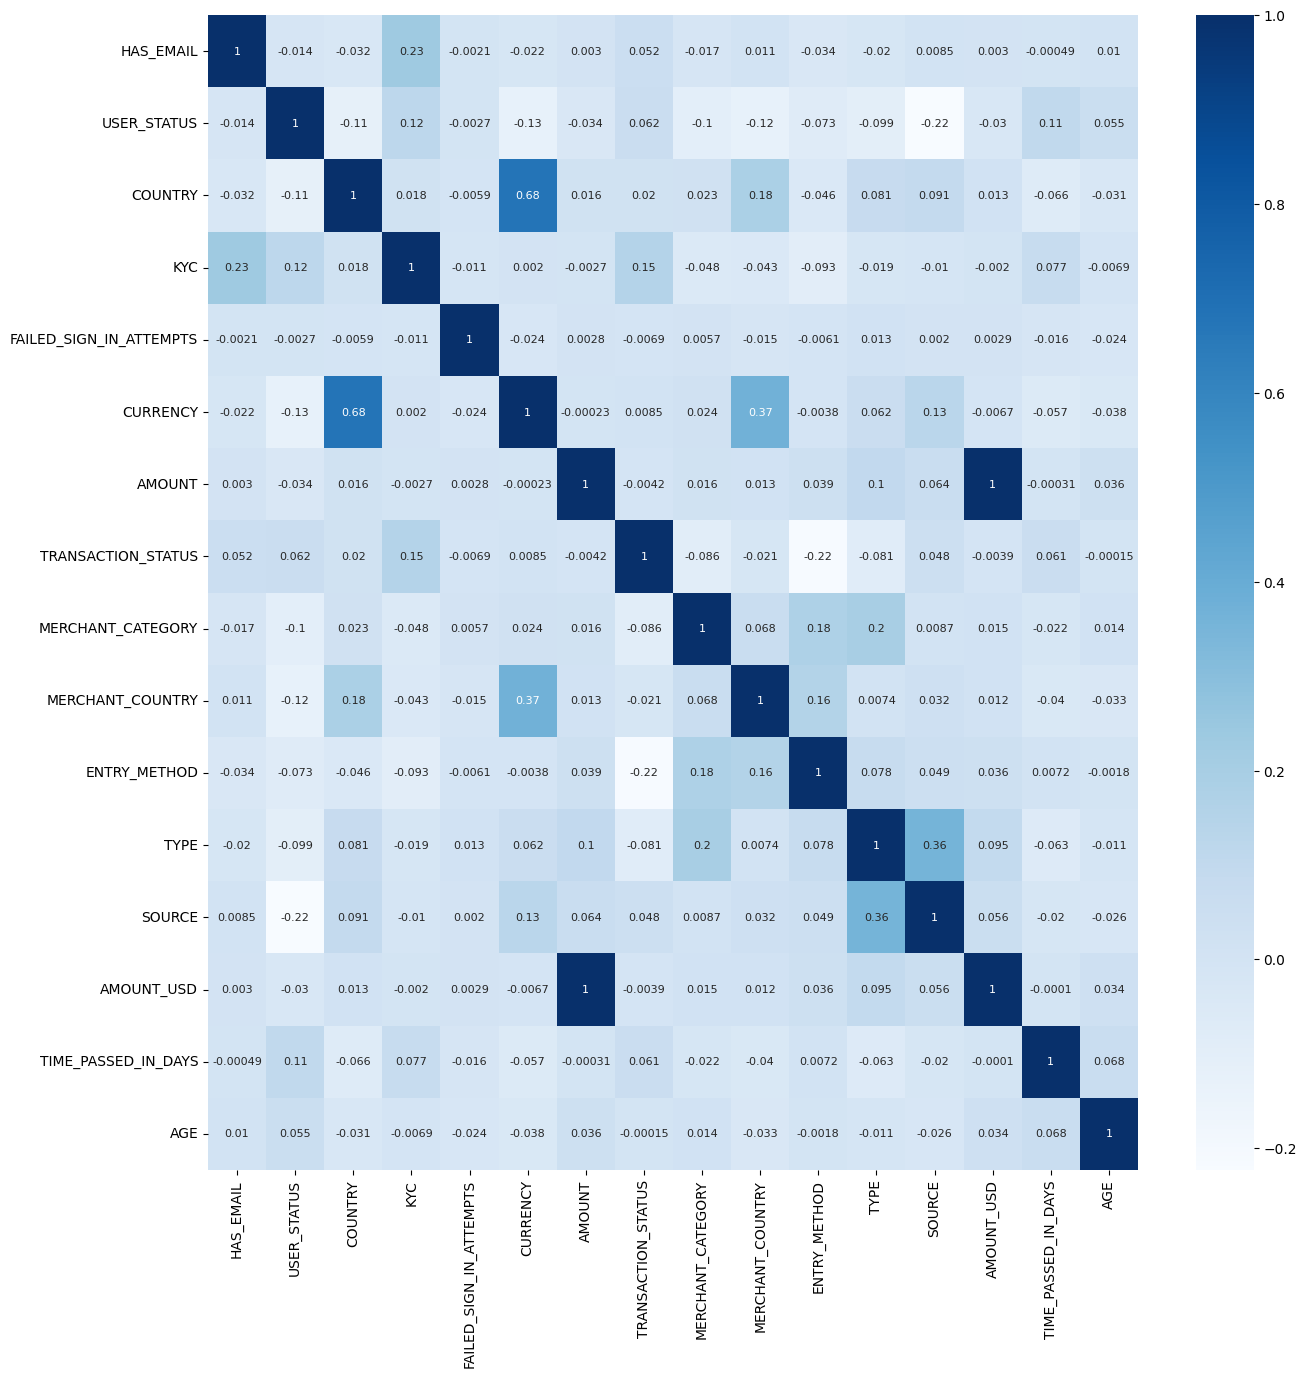

In [83]:
plt.figure(figsize=(15,15))
sns.heatmap(train_df[[col for col in train_df.iloc[:,:-86].columns if col not in ['IS_FRAUDSTER']]].corr(), 
            annot=True, cmap="Blues", 
            annot_kws={"size": 8})

In [84]:
REMOVED_FEATURES.append("AMOUNT") # Here Amount USD should be removed so that we can utlize the amount in native currency

In [85]:
train_df.drop(['AMOUNT'],axis=1,inplace=True)

### Feature Importance using XGBoost

In [86]:
# create XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(train_df.iloc[:,:-86].drop(['IS_FRAUDSTER'],axis=1), train_df['IS_FRAUDSTER'])

# get feature importance
feature_importance = xgb_model.feature_importances_

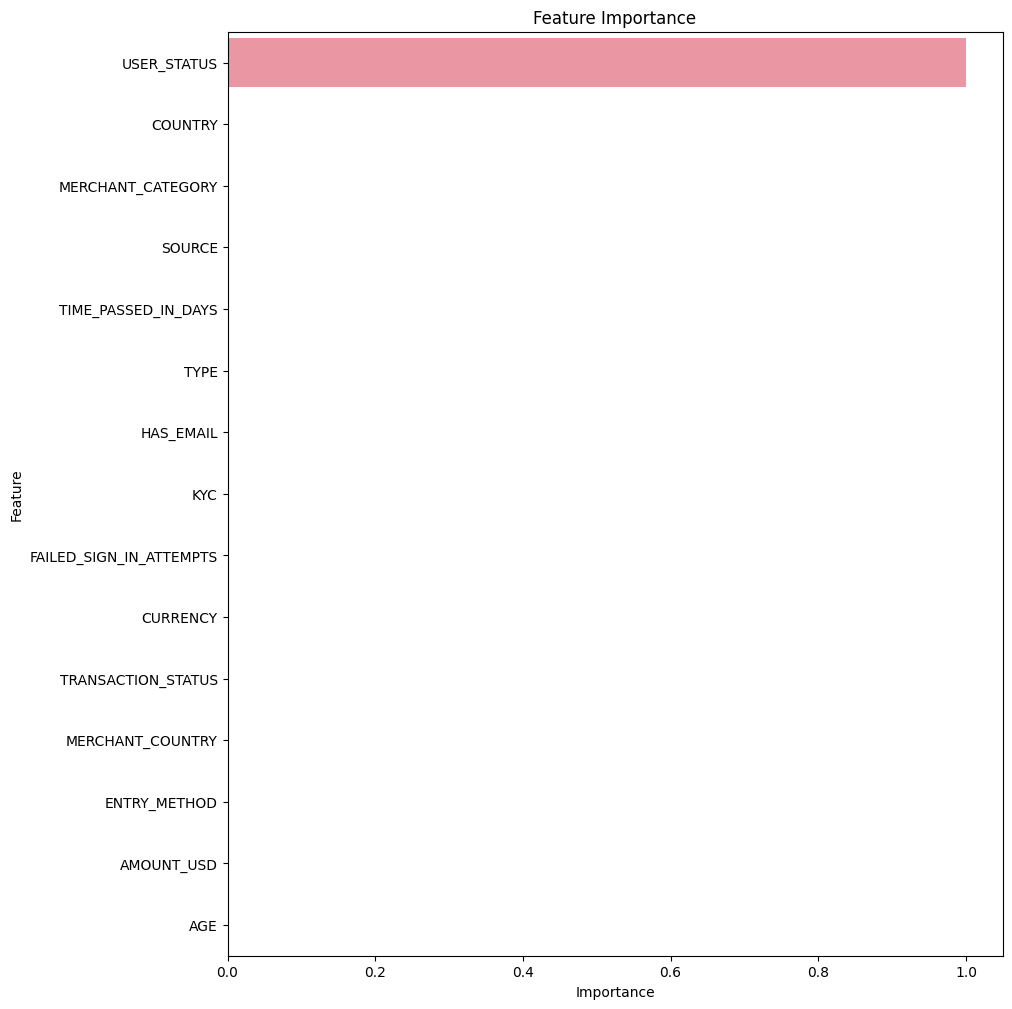

In [87]:
# create dataframe with feature importance
fi_df = pd.DataFrame({'Features': train_df.iloc[:,:-86].drop(['IS_FRAUDSTER'],axis=1).columns, 'Importance': feature_importance})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

# plot feature importance using seaborn
plt.figure(figsize=(10, 12))
sns.barplot(y=fi_df['Features'], x=fi_df['Importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [88]:
REMOVED_FEATURES.append("USER_STATUS")

In [89]:
### TRAIN DATASET ###
train_df.drop(["USER_STATUS"],axis=1,inplace=True)

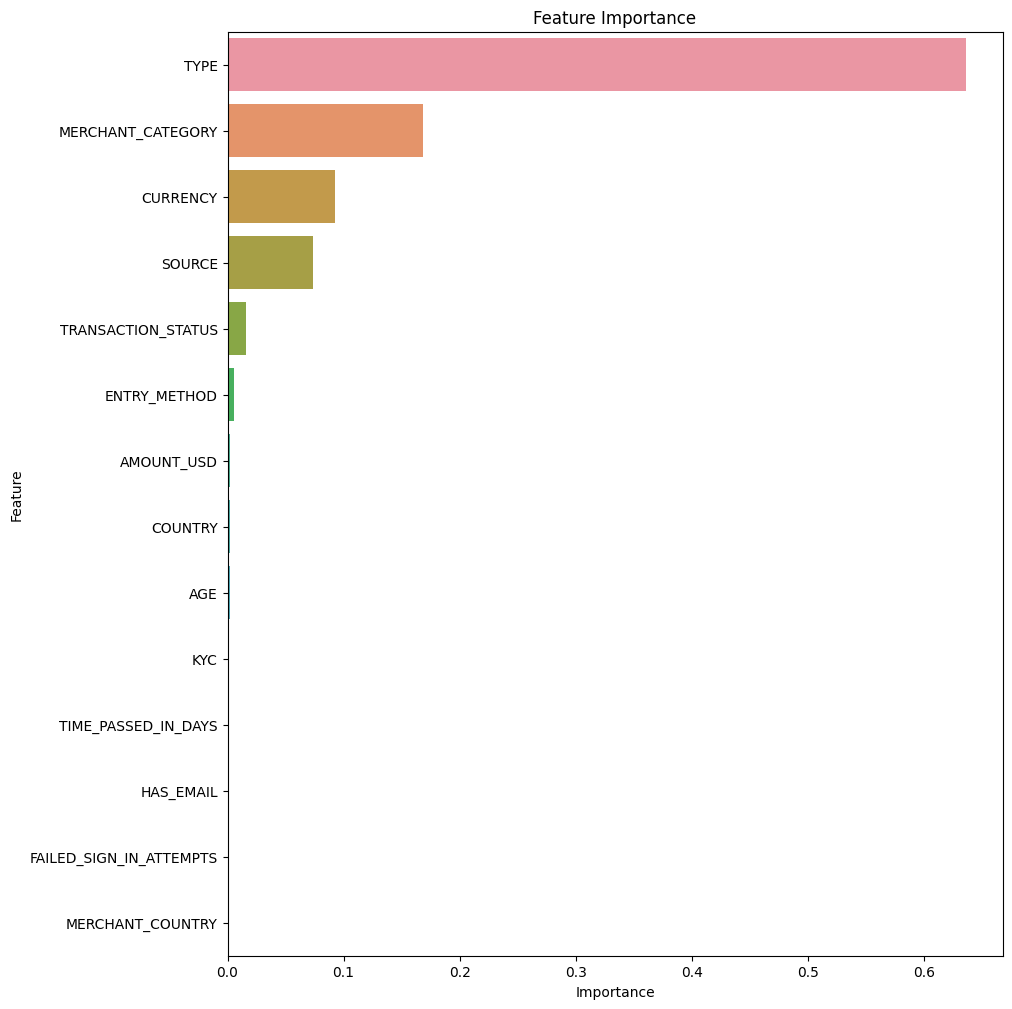

In [90]:
############# Feature Importance after Removing the Target Leakage column #############

# create XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(train_df.iloc[:,:-86].drop(['IS_FRAUDSTER'],axis=1), train_df['IS_FRAUDSTER'])

# get feature importance
feature_importance = xgb_model.feature_importances_

# create dataframe with feature importance
fi_df = pd.DataFrame({'Features': train_df.iloc[:,:-86].drop(['IS_FRAUDSTER'],axis=1).columns, 'Importance': feature_importance})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

# plot feature importance using seaborn
plt.figure(figsize=(10, 12))
sns.barplot(y=fi_df['Features'], x=fi_df['Importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [91]:
test_df.drop(REMOVED_FEATURES,axis=1,inplace=True)
val_df.drop(REMOVED_FEATURES,axis=1,inplace=True)

## Handling Imabalance in the Dataset

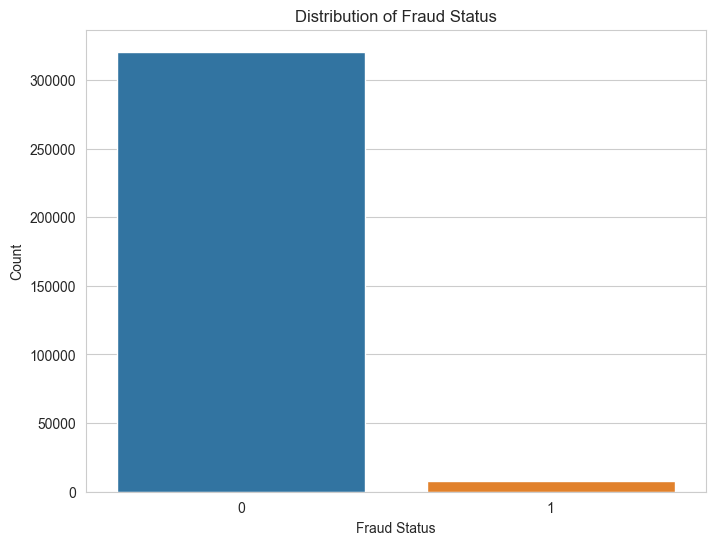

In [92]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

# create countplot
sns.countplot(x="IS_FRAUDSTER", data=train_df)

# set labels and title
plt.xlabel("Fraud Status")
plt.ylabel("Count")
plt.title("Distribution of Fraud Status")

plt.show()

In [93]:
train_df['IS_FRAUDSTER'].value_counts()

0    320613
1      7617
Name: IS_FRAUDSTER, dtype: int64

In [94]:
from ctgan import CTGAN

In [95]:
# find columns with less than 10 unique values
discrete_columns = []
for col in train_df.columns:
    if len(train_df[col].unique()) <= 100:
        discrete_columns.append(col)

In [96]:
fraud_df = train_df[train_df['IS_FRAUDSTER']==1]

In [97]:
ctgan = CTGAN(epochs=50)
ctgan.fit(fraud_df, discrete_columns)

# Create synthetic data
synthetic_fraud_data = ctgan.sample(300000)

In [98]:
synthetic_fraud_data.head()

,HAS_EMAIL,COUNTRY,KYC,FAILED_SIGN_IN_ATTEMPTS,CURRENCY,TRANSACTION_STATUS,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,TYPE,...,SI,SJ,SK,TF,TH,UA,US,VN,YT,ZA
0,1,0.036655,3,0,0.041306,6,0.113092,0.029983,0.011464,0.016682,...,0,0,0,0,0,0,0,0,0,0
1,1,0.036655,3,0,0.041306,3,0.026125,0.048468,0.029358,0.085616,...,0,0,0,0,0,0,0,0,0,0
2,1,0.036655,3,0,0.041306,6,0.028247,0.029983,0.029358,0.016682,...,0,0,0,0,0,0,0,0,0,0
3,1,0.036655,3,0,0.041306,1,0.028047,0.029983,0.019285,0.016682,...,0,0,0,0,0,0,0,0,0,0
4,1,0.036655,3,0,0.041306,3,0.027009,0.048468,0.029358,0.054784,...,0,0,0,0,0,0,0,0,0,0


In [99]:
original_and_synthetic_data = pd.concat([train_df,synthetic_fraud_data],axis=0)

In [100]:
original_and_synthetic_data['IS_FRAUDSTER'].value_counts()

0    320613
1    307617
Name: IS_FRAUDSTER, dtype: int64

In [101]:
original_and_synthetic_data.to_csv("balanced_dataset(original_and_synthetic).csv",index=False)
test_df.to_csv("test_dataset.csv",index=False)
val_df.to_csv("validation_dataset.csv",index=False)

## Auto-ML

In [102]:
import pandas as pd

In [103]:
RANDOM_STATE_SEED = 100

In [104]:
original_and_synthetic_data = pd.read_csv(r"..\\jupyter_notebook\\balanced_dataset(original_and_synthetic).csv",
                                          low_memory=True)

In [105]:
original_and_synthetic_data['IS_FRAUDSTER'].value_counts()

0    320613
1    307617
Name: IS_FRAUDSTER, dtype: int64

In [106]:
test_df = pd.read_csv(r"..\\jupyter_notebook\\test_dataset.csv",
                                          low_memory=True)

In [107]:
test_df['IS_FRAUDSTER'].value_counts()

0    114504
1      2721
Name: IS_FRAUDSTER, dtype: int64

In [108]:
val_df = pd.read_csv(r"..\\jupyter_notebook\\validation_dataset.csv",
                                          low_memory=True)

In [109]:
val_df['IS_FRAUDSTER'].value_counts()

0    137405
1      3265
Name: IS_FRAUDSTER, dtype: int64

In [110]:
# init setup 
from pycaret.classification import *
clf_experiments = setup(
                        data = original_and_synthetic_data,
                        target = 'IS_FRAUDSTER',
                        test_data = val_df,
                        fold_strategy='stratifiedkfold', # Cross validation using stratified k-fold
                        fold=3, # 3 fold for cross validation
                        fold_shuffle=True, # Shuffle the portions of training dataset for cross validation
                        n_jobs=-1,
                        data_split_stratify=True, # split the whole dataset using stratified sampling 
                        session_id=RANDOM_STATE_SEED
                        )

### Logistic Regression

In [111]:
logitic_regression_model = create_model('lr')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:21:08
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7859,0.8432,0.7751,0.7178,0.7454,0.5611,0.5623
1,0.8109,0.9018,0.8052,0.7469,0.7750,0.6123,0.6136
2,0.8123,0.8810,0.8336,0.7368,0.7822,0.6184,0.6220
Mean,0.8030,0.8753,0.8046,0.7338,0.7675,0.5973,0.5993
Std,0.0121,0.0243,0.0239,0.0121,0.0159,0.0257,0.0264


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [112]:
tuned_logistic_regression_model, lr_tuner  = tune_model(logitic_regression_model,
                                            optimize='F1',
                                            choose_better = True,
                                            search_library = 'scikit-optimize',
                                            search_algorithm = 'bayesian',
                                            return_tuner=True)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:22:35
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7859,0.8432,0.7751,0.7178,0.7454,0.5611,0.5623
1,0.8137,0.8813,0.8348,0.7385,0.7837,0.6212,0.6248
2,0.8123,0.8810,0.8336,0.7367,0.7822,0.6184,0.6220
Mean,0.8040,0.8685,0.8145,0.7310,0.7704,0.6002,0.6030
Std,0.0128,0.0179,0.0279,0.0094,0.0177,0.0277,0.0288


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [117]:
save_model(tuned_logistic_regression_model, 'saved_logistic_regression_model') 

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\SHUBHA~1\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['HAS_EMAIL', 'COUNTRY', 'KYC',
                                              'FAILED_SIGN_IN_ATTEMPTS',
                                              'CURRENCY', 'TRANSACTION_STATUS',
                                              'MERCHANT_CATEGORY',
                                              'MERCHANT_COUNTRY', 'ENTRY_METHOD',
                                              'TYPE', 'SOURCE', 'AMOUNT_USD',
                                              'TIME_PASSED_IN_DAYS', 'AGE', 'AE...
                                                               missing_values=nan,
                                                               strategy='most_frequent',
                                                               verbose='deprecated'))),
                 ('trained_

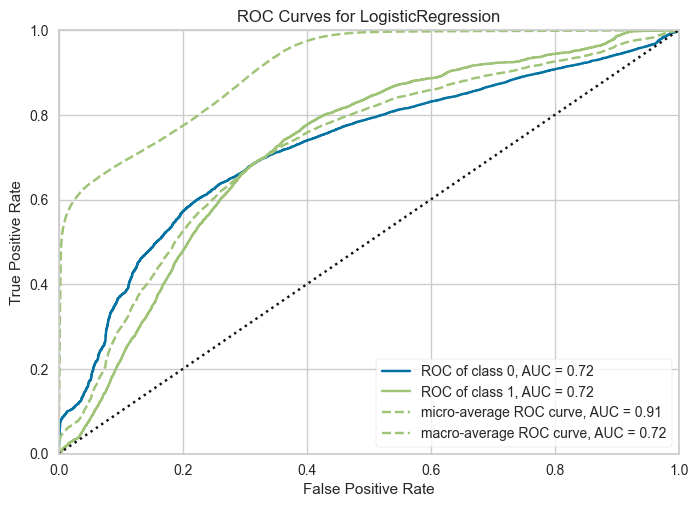

In [121]:
## ROC AUC CURVE FOR LOGISTICE REGRESSION
plot_model(tuned_logistic_regression_model,
           plot = 'auc',
           use_train_data = False)

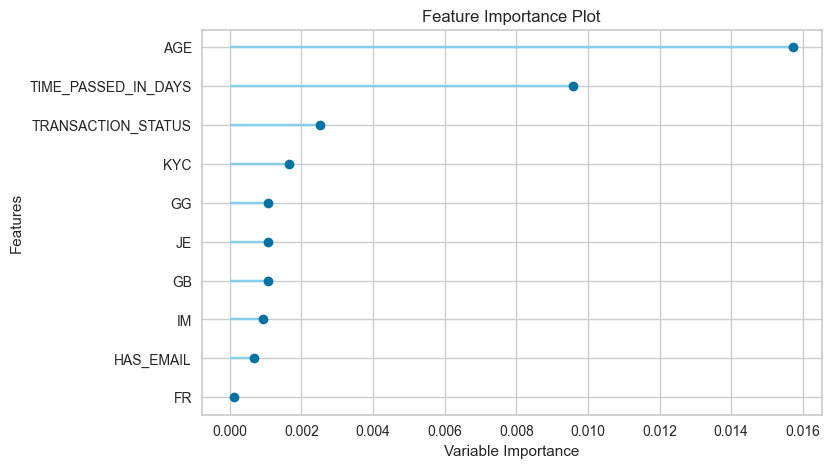

In [125]:
plot_model(tuned_logistic_regression_model, plot='feature')

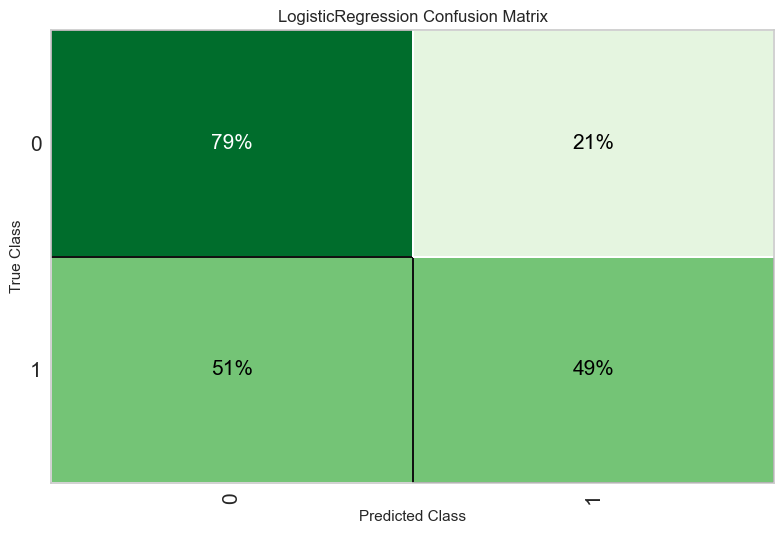

In [124]:
## CONFUSION MATRIX FOR LOGISTICE REGRESSION
plot_model(tuned_logistic_regression_model,
           plot = 'confusion_matrix',
           plot_kwargs = {'percent' : True},
           use_train_data = False)

### Decision Trees

In [113]:
decision_tree_model = create_model('dt')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:28:11
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9961,0.9960,0.9954,0.9949,0.9952,0.9919,0.9919
1,0.9963,0.9962,0.9956,0.9953,0.9954,0.9923,0.9923
2,0.9961,0.9961,0.9957,0.9948,0.9952,0.9920,0.9920
Mean,0.9962,0.9961,0.9956,0.9950,0.9953,0.9921,0.9921
Std,0.0001,0.0001,0.0001,0.0002,0.0001,0.0002,0.0002


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [114]:
tuned_decision_tree_model, dt_tuner  = tune_model(decision_tree_model,
                                            optimize='F1',
                                            choose_better = True,
                                            search_library = 'scikit-optimize',
                                            search_algorithm = 'bayesian',
                                            return_tuner=True)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:28:50
Status,. . . . . . . . . . . . . . . . . .,Selecting Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Decision Tree Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9968,0.9996,0.9932,0.9988,0.9960,0.9933,0.9933
1,0.9970,0.9996,0.9935,0.9990,0.9962,0.9937,0.9937
2,0.9971,0.9996,0.9936,0.9991,0.9963,0.9939,0.9939
Mean,0.9969,0.9996,0.9934,0.9990,0.9962,0.9936,0.9936
Std,0.0001,0.0000,0.0002,0.0001,0.0001,0.0002,0.0002


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [118]:
save_model(tuned_decision_tree_model, 'saved_decision_tree_model') 

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\SHUBHA~1\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['HAS_EMAIL', 'COUNTRY', 'KYC',
                                              'FAILED_SIGN_IN_ATTEMPTS',
                                              'CURRENCY', 'TRANSACTION_STATUS',
                                              'MERCHANT_CATEGORY',
                                              'MERCHANT_COUNTRY', 'ENTRY_METHOD',
                                              'TYPE', 'SOURCE', 'AMOUNT_USD',
                                              'TIME_PASSED_IN_DAYS', 'AGE', 'AE...
                                                               strategy='most_frequent',
                                                               verbose='deprecated'))),
                 ('trained_model',
                  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,


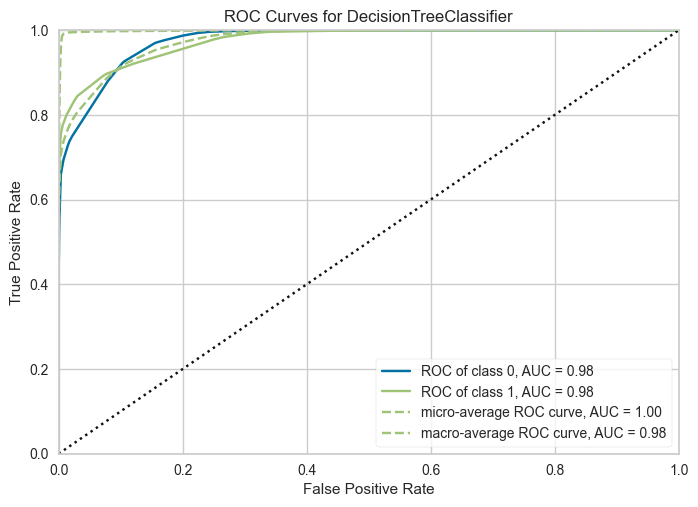

In [126]:
## ROC AUC CURVE FOR DECISION TREE
plot_model(tuned_decision_tree_model,
           plot = 'auc',
           use_train_data = False)

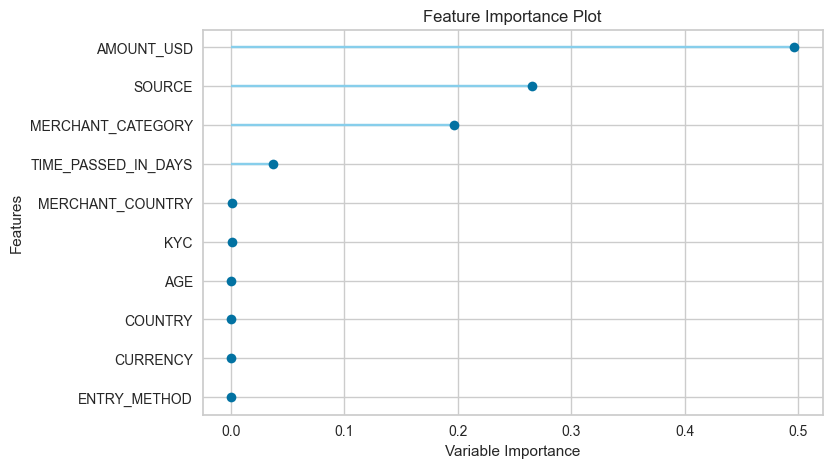

In [127]:
plot_model(tuned_decision_tree_model, plot='feature')

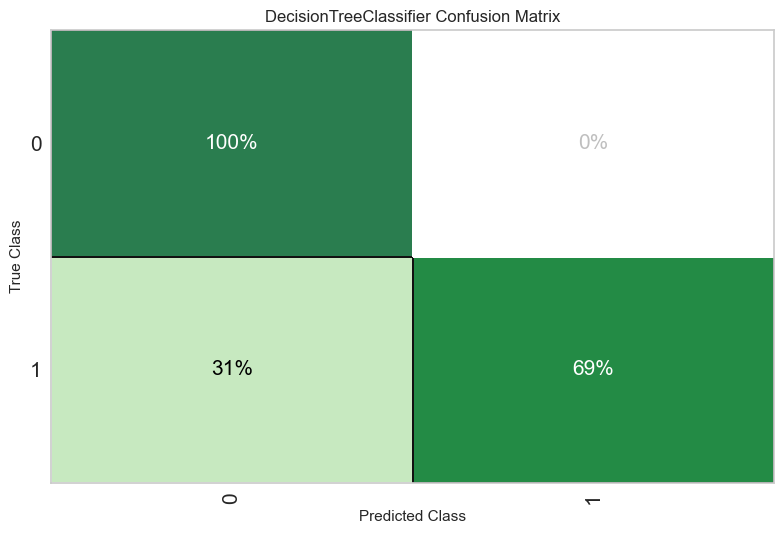

In [128]:
## CONFUSION MATRIX FOR DECISION TREE
plot_model(tuned_decision_tree_model,
           plot = 'confusion_matrix',
           plot_kwargs = {'percent' : True},
           use_train_data = False)

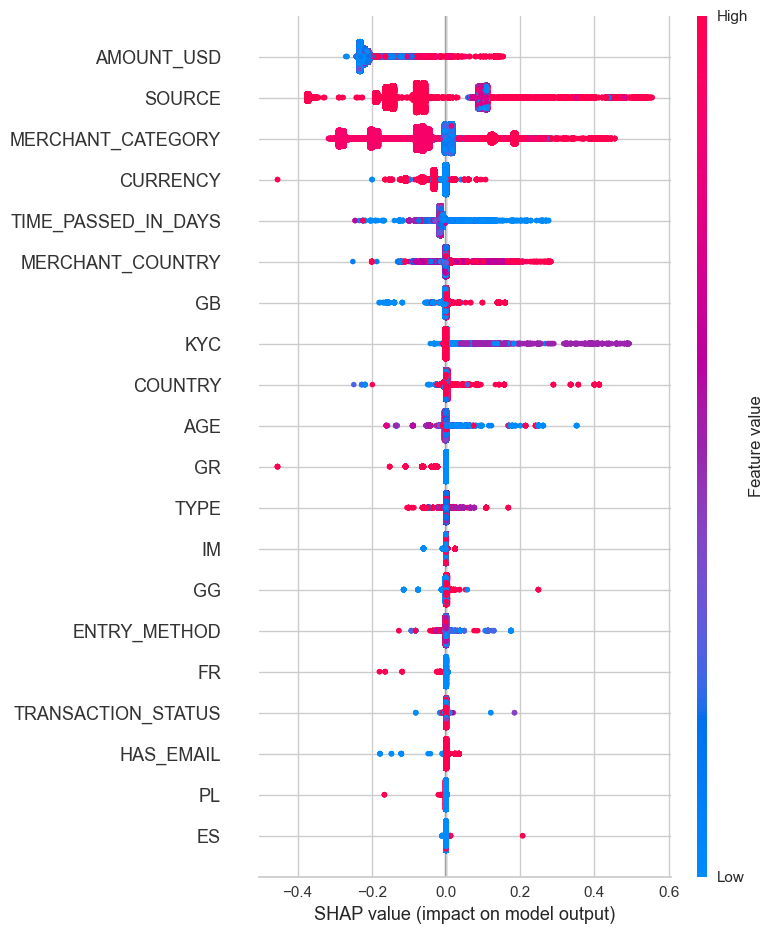

In [133]:
interpret_model(tuned_decision_tree_model)

### Random Forest (Bagging Algorithm)

In [115]:
random_forest_model = create_model('rf')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:52:59
Status,. . . . . . . . . . . . . . . . . .,Selecting Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9976,0.9998,0.9951,0.9990,0.9971,0.9951,0.9951
1,0.9976,0.9997,0.9950,0.9990,0.9970,0.9950,0.9950
2,0.9977,0.9998,0.9951,0.9992,0.9971,0.9952,0.9952
Mean,0.9976,0.9998,0.9951,0.9991,0.9971,0.9951,0.9951
Std,0.0000,0.0000,0.0000,0.0001,0.0001,0.0001,0.0001


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [116]:
tuned_random_forest_model, rf_tuner  = tune_model(random_forest_model,
                                            optimize='F1',
                                            choose_better = True,
                                            search_library = 'scikit-optimize',
                                            search_algorithm = 'bayesian',
                                            return_tuner=True)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:55:12
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9968,0.9998,0.9932,0.9988,0.9960,0.9933,0.9933
1,0.9969,0.9998,0.9933,0.9989,0.9961,0.9935,0.9935
2,0.9969,0.9998,0.9934,0.9990,0.9962,0.9936,0.9937
Mean,0.9969,0.9998,0.9933,0.9989,0.9961,0.9935,0.9935
Std,0.0001,0.0000,0.0001,0.0001,0.0001,0.0001,0.0001


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [119]:
save_model(tuned_random_forest_model, 'saved_random_forest_model') 

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\SHUBHA~1\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['HAS_EMAIL', 'COUNTRY', 'KYC',
                                              'FAILED_SIGN_IN_ATTEMPTS',
                                              'CURRENCY', 'TRANSACTION_STATUS',
                                              'MERCHANT_CATEGORY',
                                              'MERCHANT_COUNTRY', 'ENTRY_METHOD',
                                              'TYPE', 'SOURCE', 'AMOUNT_USD',
                                              'TIME_PASSED_IN_DAYS', 'AGE', 'AE...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='gini',
                                         max_depth=None, max_features='sqrt',
                                         max_leaf_nodes=Non

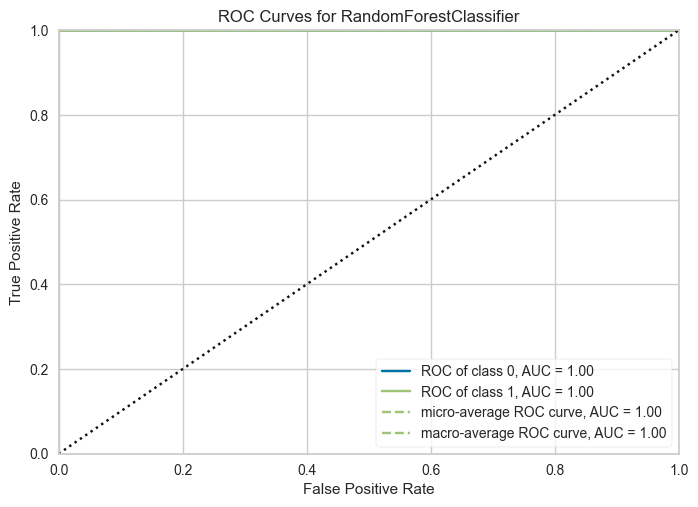

In [129]:
## ROC AUC CURVE FOR RANDOM FOREST
plot_model(tuned_random_forest_model,
           plot = 'auc',
           use_train_data = False)

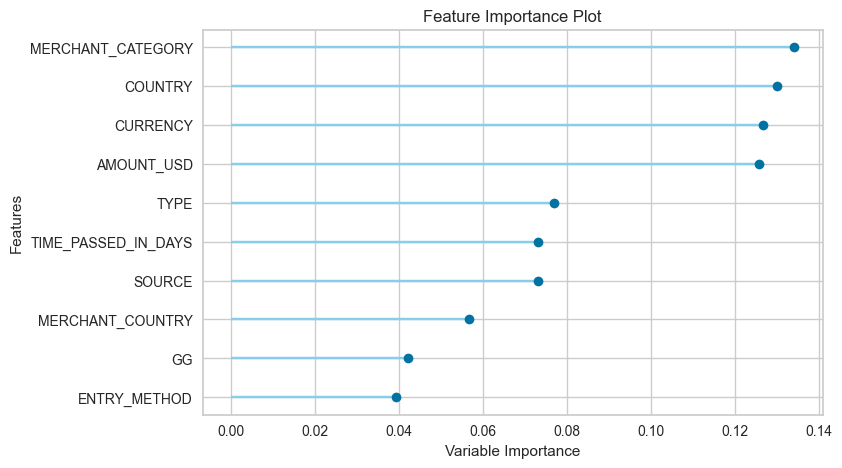

In [131]:
plot_model(tuned_random_forest_model, plot='feature')

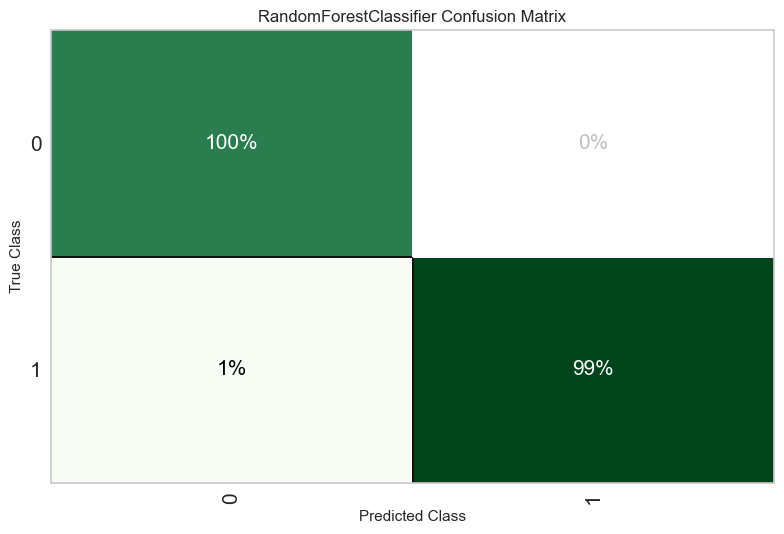

In [130]:
## CONFUSION MATRIX FOR RANDOM FOREST
plot_model(tuned_random_forest_model,
           plot = 'confusion_matrix',
           plot_kwargs = {'percent' : True},
           use_train_data = False)

In [134]:
interpret_model(tuned_random_forest_model)

### XGBoost (Extreme Boosting Algorithm)

In [ ]:
xgboost_model = create_model('xgboost')

In [ ]:
tuned_xgboost_model, xgboost_tuner  = tune_model(xgboost_model,
                                            optimize='F1',
                                            choose_better = True,
                                            search_library = 'scikit-optimize',
                                            search_algorithm = 'bayesian',
                                            return_tuner=True)

In [118]:
save_model(xgboost_model, 'saved_xgboost_model') 

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\SHUBHA~1\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['HAS_EMAIL', 'COUNTRY', 'KYC',
                                              'FAILED_SIGN_IN_ATTEMPTS',
                                              'CURRENCY', 'TRANSACTION_STATUS',
                                              'MERCHANT_CATEGORY',
                                              'MERCHANT_COUNTRY', 'ENTRY_METHOD',
                                              'TYPE', 'SOURCE', 'AMOUNT_USD',
                                              'TIME_PASSED_IN_DAYS', 'AGE', 'AE...
                                grow_policy=None, importance_type=None,
                                interaction_constraints=None, learning_rate=None,
                                max_bin=None, max_cat_threshold=None,
                                max_cat_to_onehot=None, max_del

## Prediction

In [10]:
from pycaret.classification import *
from pycaret.classification import load_model 

saved_xgboost_model = load_model('saved_xgboost_model')

Transformation Pipeline and Model Successfully Loaded


In [11]:
predictions_df = predict_model(saved_xgboost_model, data=test_df)

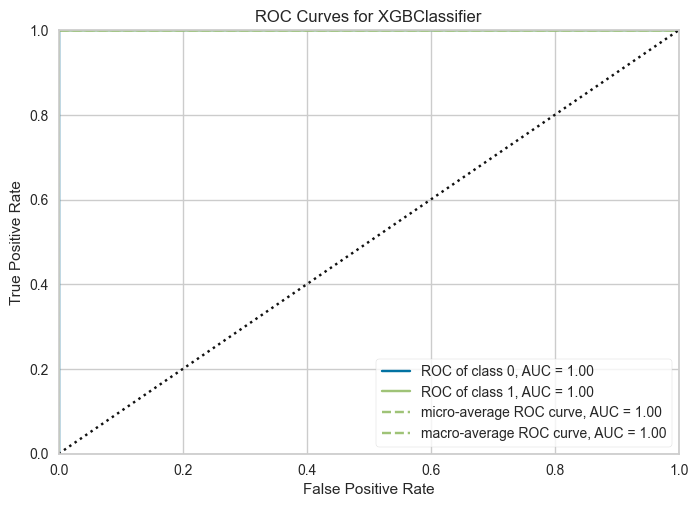

In [121]:
# ROC_AUC CURVE
plot_model(saved_xgboost_model, plot = 'auc')

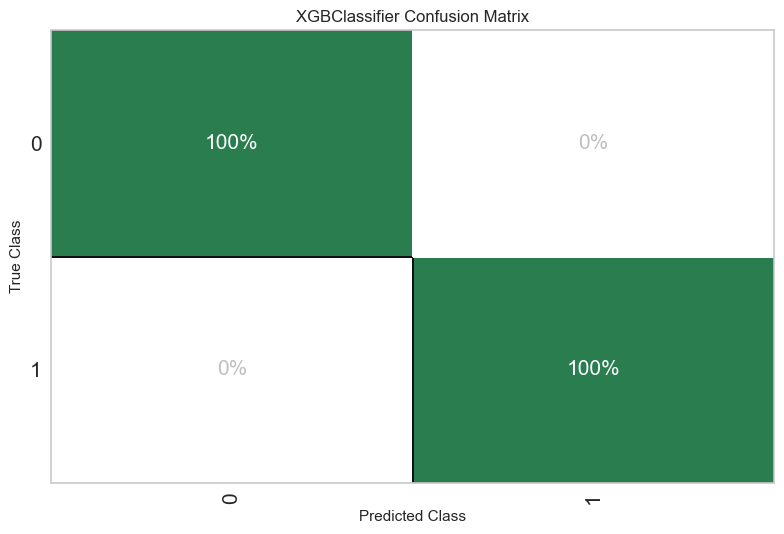

In [123]:
plot_model(saved_xgboost_model,
           plot = 'confusion_matrix',
           plot_kwargs = {'percent' : True},
           use_train_data = False)

In [12]:
## Interpret Model
interpret_model(saved_xgboost_model)

ValueError: _CURRENT_EXPERIMENT global variable is not set. Please run setup() first.